In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW


In [5]:
def generate_data(n=1000, seed=0):
    rng = np.random.default_rng(seed)
    
    X = rng.normal(0, 0.5, size=(n, 4))
    a_beta = np.array([1, 1, 0, 0])
    a_logit = X @ a_beta
    a_prop = expit(a_logit)
    a = rng.binomial(1, a_prop)

    y_beta = np.array([-1, -1, -1, -1])
    effect = 0
    y = X @ y_beta + a * effect + rng.normal(0, 1, size=n)
    
    X = pd.DataFrame(X, columns=["xay1", "xay2", "xy1", "xy2"])
    a = pd.Series(a, name="a")
    y = pd.Series(y, name="y")
    return X, a, y

In [20]:
n_repeats = 10000
results = []
for i in range(n_repeats):
    X, a, y = generate_data(seed=i)
    estimator = LogisticRegression(penalty="none", max_iter=1000)
    ipw_conf = IPW(estimator).fit(X[["xay1", "xay2"]], a)
    conf_effect = ipw_conf.estimate_population_outcome(X[["xay1", "xay2"]], a, y)
    conf_effect = conf_effect[1] - conf_effect[0]
    ipw_prog = IPW(estimator).fit(X, a)
    prog_effect = ipw_prog.estimate_population_outcome(X, a, y)
    prog_effect = prog_effect[1] - prog_effect[0]
    raw_effect = y.groupby(a).mean()
    raw_effect = raw_effect[1] - raw_effect[0]
    results.append((conf_effect, prog_effect, raw_effect))
results = pd.DataFrame(results, columns=["conf", "prog", "raw"])
results

,conf,prog,raw
0,-0.040933,-0.023923,-0.486133
1,0.015296,0.020771,-0.445688
2,-0.129673,-0.179528,-0.576257
3,0.027104,0.052811,-0.348902
4,0.086357,0.038473,-0.340843
...,...,...,...
9995,0.015035,0.064558,-0.463390
9996,-0.142844,-0.083009,-0.581268
9997,-0.020878,-0.011107,-0.440235
9998,-0.128003,-0.162208,-0.544827


In [21]:
results_long = results.reset_index().melt(
    value_vars=["conf", "prog", "raw"],
    id_vars="index",
    value_name="bias",
    var_name="model",
)
results_long

,index,model,bias
0,0,conf,-0.040933
1,1,conf,0.015296
2,2,conf,-0.129673
3,3,conf,0.027104
4,4,conf,0.086357
...,...,...,...
29995,9995,raw,-0.463390
29996,9996,raw,-0.581268
29997,9997,raw,-0.440235
29998,9998,raw,-0.544827


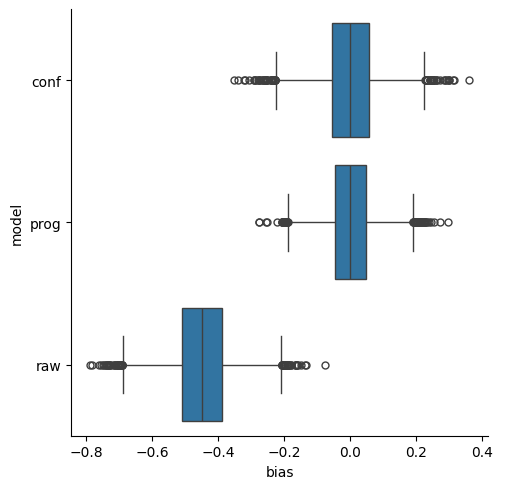

In [22]:
sns.catplot(
    data=results_long,
    x="bias",
    y="model",
    kind="box",
)

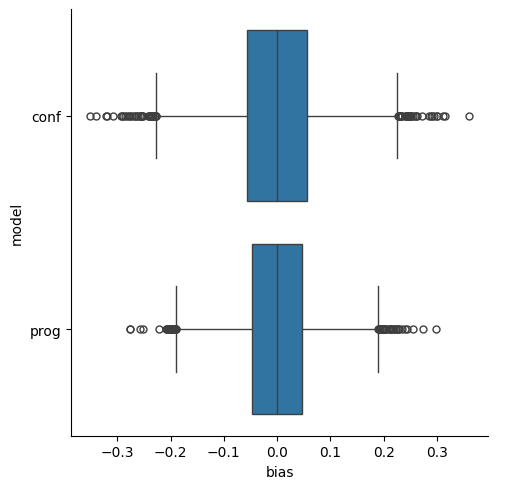

In [23]:
sns.catplot(
    data=results_long.query("model != 'raw'"),
    x="bias",
    y="model",
    kind="box",
)

In [25]:
results_long.groupby("model")["bias"].var()

model
conf    0.007212
prog    0.004955
raw     0.008008
Name: bias, dtype: float64